CS 4701 AI Prac

no



Names: Quinn Liu, Olivia Lu, Eli Zhang

Netids: qjl3, ol48, ekz5

Don't forget to share your newly copied notebook with your partner!


# Task and dataset

---

1. Obtain the data from Kaggle at https://www.kaggle.com/google/tinyquickdraw.
  This only needs to be done once. 
2. Unzip the data. Put it into your google drive, and mount it on colab as per below:

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d google/tinyquickdraw

In [ ]:
! mkdir /content/drive/My\ Drive/CS\ 4701\ Prac/data
! unzip /content/drive/My\ Drive/CS\ 4701\ Prac/tinyquickdraw.zip -d /content/drive/My\ Drive/CS\ 4701\ Prac/data

mkdir: cannot create directory ‘/content/drive/My Drive/CS 4701 Prac/data’: No such file or directory
unzip:  cannot find or open /content/drive/My Drive/CS 4701 Prac/tinyquickdraw.zip, /content/drive/My Drive/CS 4701 Prac/tinyquickdraw.zip.zip or /content/drive/My Drive/CS 4701 Prac/tinyquickdraw.zip.ZIP.


# Run this code every time to start: 

In [1]:
! pip install ndjson
! pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 5.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [7]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import ndjson
from PIL import Image, ImageDraw
import torch
from torch.utils.data import DataLoader, IterableDataset
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, models, transforms    
import torchvision.transforms as transforms              # composable transforms
import json
import ndjson
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm, trange
from datetime import datetime
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error
from sklearn.model_selection import train_test_split # resampling method
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from collections import Counter
# import sklearn

drive.mount('/content/drive', force_remount=True)

IMG_SIZE = "28"
# IMG_SIZE = "255"

data_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "data", "quickdraw_simplified")
flattened_data_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "data", IMG_SIZE)
print()
# dataset = np.load(data_path, encoding='latin1', allow_pickle=True)

# print('The scikit-learn version is {}.'.format(sklearn.__version__))


Mounted at /content/drive



In [17]:
''' Creates 255x255 images '''
# def draw_it(raw_strokes):
#     image = Image.new("P", (255,255), color=255)
#     image_draw = ImageDraw.Draw(image)

#     # for stroke in eval(raw_strokes):
#     for stroke in raw_strokes:
#         for i in range(len(stroke[0])-1):

#             image_draw.line([stroke[0][i], 
#                              stroke[1][i],
#                              stroke[0][i+1], 
#                              stroke[1][i+1]],
#                             fill=0, width=3)
#     return np.array(image)
''' Creates 28x28 images '''
def draw_it(raw_strokes):
    image = Image.new("P", (28,28), color=255)
    image_draw = ImageDraw.Draw(image)

    # for stroke in eval(raw_strokes):
    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i] / 8.5, 
                             stroke[1][i] / 8.5,
                             stroke[0][i+1] / 8.5, 
                             stroke[1][i+1] / 8.5],
                            fill=0, width=1)
    return np.array(image)

def flatten_data(input):
  temp = np.array(input)
  return temp.reshape(temp.shape[0],-1)


# *** DO !! NOT!! RUN EVERY TIME ;;-;;***

### **Calculate the centroids**

In [ ]:
'''
Create the centroids
'''
ct = 0
paths = os.listdir(data_path)
path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac")

centroids = {}
cts = {}

for i, f in enumerate(paths):
    print("Progress:", i, "/", len(paths))
    with open(data_path + "/" + f) as json_file:
        d = ndjson.load(json_file)
        label = f[:-7]

        for entry in d:
            if ct % 80 == 0:  ## only take 1/30 of data set for disk space concerns
                full_image = draw_it(entry["drawing"])

                if label not in centroids:
                  centroids[label] = full_image
                  cts[label] = 1
                else:
                  centroids[label] += full_image
                  cts[label] += 1

            ct += 1

for k,v in centroids.items():
  centroids[k] = v / cts[k] #take average
  plt.imshow(centroids[k], cmap="gray")
  # plt.show()
  plt.savefig(path +'/centroids/'+IMG_SIZE+"/"+k+'.png')

pickle.dump( centroids, open(flattened_data_path + "/centroids.p", "wb" ) )



### **Centroid Clusters (K-Means)**

In [36]:
X = np.array([[1, 2], [1, 4], [1, 0],[4, 2], [4, 0], [4, 4],[4, 5], [0, 1], [2, 2],[3, 2], [5, 5], [1, -1]])
kmeans = MiniBatchKMeans(n_clusters=3,random_state=0,batch_size=6)
kmeans = kmeans.partial_fit(X[0:6,:])
kmeans = kmeans.partial_fit(X[6:12,:])
print(kmeans.cluster_centers_)

# ah = []
# x = np.array([1,2])
# y = np.array([3,4])
# ah = x
# ah = ah.append(y)
# print(ah)
test = [[1,2],[3,4]]
print(np.array(test))

[[3.66666667 1.33333333]
 [3.5        4.5       ]
 [1.         0.8       ]]
[[1 2]
 [3 4]]


In [ ]:
ct = 0
paths = os.listdir(data_path)
path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac")

centroids = {} #store kmeans models for each label
data = {} #store data for each label

for i, f in enumerate(paths):
    print("Progress:", i, "/", len(paths))
    with open(data_path + "/" + f) as json_file:
        d = ndjson.load(json_file)
        label = f[:-7]
        kmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=1)
        internal = 0

        for entry in d:
            if ct % 60 == 0:  ## only take 1/30 of data set for disk space concerns
                full_image = draw_it(entry["drawing"])

                flat = full_image.flatten()

                #append in data
                if label not in data:
                  data[label] = [flat.tolist()]
                else:
                  data[label] += [flat.tolist()]

            ct += 1

        #partial fit kmeans model if enough data
        if len(data[label]) > 10:
          kmeans = kmeans.partial_fit(np.array(data[label]))
          data[label] = []
          centroids[label] = kmeans.cluster_centers_


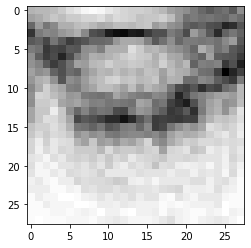

In [50]:
'''
save cluster centers
'''
for k,v in centroids.items():
  iter = 1
  for cluster in v:
    edit = np.reshape(cluster, (-1,28))
    plt.imshow(edit, cmap="gray")
    # plt.show()
    plt.savefig(path +'/centroids/'+IMG_SIZE+"/clusters/"+k+str(iter)+'.png')
    iter += 1

# print("centroids", centroids)
pickle.dump( centroids, open(flattened_data_path + "/centroids_clusters.p", "wb" ) )

### **Split into train/valid/test**

In [ ]:
'''
Make train/valid/test pickle files
'''
ct = 0
split = 0
paths = os.listdir(data_path)

for i, f in enumerate(paths):
    print("Progress:", i, "/", len(paths))
    with open(data_path + "/" + f) as json_file:
        train_data, train_label = [], []
        valid_data, valid_label = [], []
        test_data, test_label = [], []
        pickle_data_amount = 0
        d = ndjson.load(json_file)
        label = f[:-7]
        for entry in d:
            if ct % (45) == 0:  ## only take 1% of data set for disk space concerns
                full_image = draw_it(entry["drawing"])

                if split >= 85:
                  if split == 100: #reset
                    split = 0
                  test_data.append(full_image)
                  test_label.append(label)
                elif split >= 70:
                  valid_data.append(full_image)
                  valid_label.append(label)
                else:
                  train_data.append(full_image)
                  train_label.append(label)
                split += 1
                pickle_data_amount += 1

            ct += 1
            if pickle_data_amount > 200000:
                print("Appending some data for label {}...".format(label))
                pickle.dump(train_data, open(flattened_data_path + "/train_data.p", "ab"))
                pickle.dump(train_label, open(flattened_data_path + "/train_label.p", "ab"))
                pickle.dump(valid_data, open(flattened_data_path + "/valid_data.p", "ab"))
                pickle.dump(valid_label, open(flattened_data_path + "/valid_label.p", "ab"))
                pickle.dump(test_data, open(flattened_data_path + "/test_data.p", "ab"))
                pickle.dump(test_label, open(flattened_data_path + "/test_label.p", "ab"))
                train_data, valid_data, test_data = [], [], []
                train_label, valid_label, test_label = [], [], []
                pickle_data_amount = 0
        pickle.dump(train_data, open(flattened_data_path + "/train_data.p", "ab"))
        pickle.dump(train_label, open(flattened_data_path + "/train_label.p", "ab"))
        pickle.dump(valid_data, open(flattened_data_path + "/valid_data.p", "ab"))
        pickle.dump(valid_label, open(flattened_data_path + "/valid_label.p", "ab"))
        pickle.dump(test_data, open(flattened_data_path + "/test_data.p", "ab"))
        pickle.dump(test_label, open(flattened_data_path + "/test_label.p", "ab"))

        print("Done appending data for label {}...".format(label))
print("Done flattening all data and labels!")


Progress: 0 / 140
Done appending data for label The Eiffel Tower...
Progress: 1 / 140
Done appending data for label The Mona Lisa...
Progress: 2 / 140
Done appending data for label angel...
Progress: 3 / 140
Done appending data for label ant...
Progress: 4 / 140
Done appending data for label apple...
Progress: 5 / 140
Done appending data for label banana...
Progress: 6 / 140
Done appending data for label bathtub...
Progress: 7 / 140
Done appending data for label beach...
Progress: 8 / 140
Done appending data for label beard...
Progress: 9 / 140
Done appending data for label bee...
Progress: 10 / 140
Done appending data for label binoculars...
Progress: 11 / 140
Done appending data for label bird...
Progress: 12 / 140
Done appending data for label book...
Progress: 13 / 140
Done appending data for label bowtie...
Progress: 14 / 140
Done appending data for label brain...
Progress: 15 / 140
Done appending data for label broccoli...
Progress: 16 / 140
Done appending data for label bucket..

In [ ]:
'''
make condensed knn training set...
around 1000 examples per category
'''
paths = os.listdir(data_path)
for i, f in enumerate(paths):
    print("Progress:", i, "/", len(paths))
    with open(data_path + "/" + f) as json_file:
        train_data, train_label = [], []

        # pickle_data_amount = 0
        d = ndjson.load(json_file)
        label = f[:-7]
        limit = 0
        for entry in d:
            if limit > 1000: #only take 1000 examples from each category
              break
            if ct % 40 == 0:  ## only take 1/30 of data set for disk space concerns
                full_image = draw_it(entry["drawing"])

                train_data.append(full_image)
                train_label.append(label)
            limit += 1

            ct += 1
        pickle.dump(train_data, open(flattened_data_path + "/packed_data.p", "ab"))
        pickle.dump(train_label, open(flattened_data_path + "/packed_label.p", "ab"))

print("DONEEE")


In [ ]:
## Updates all the drive contents (but you need to remount)
drive.flush_and_unmount()

In [ ]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

# **KNN Utils (run every time)**

In [52]:
def get_centroids(clusters=False):
  train_data, train_label = [], []
  print("HIHIHIHI", clusters)
  if clusters:
    centroids = pickle.load( open( flattened_data_path + "/centroids_clusters.p", "rb" ) )
    for k,v in centroids.items():
      for cluster in v:
        train_data.append(cluster)
        train_label.append(k)

  else:
    centroids = pickle.load( open( flattened_data_path + "/centroids.p", "rb" ) )
    for k,v in centroids.items(): #Apple --> centroid data
      train_data.append(v)
      train_label.append(k)

  train_data = np.array(train_data)
  train_label = np.array(train_label)

  return (train_data, train_label)


# KNN CLASSIFICATION (scratch)

## helper functions

In [ ]:
def l2distance(X1, X2):
    """
    l2distance(X1, X2) computes Euclidean distance matrix.
                        Distance between every point in X1 with every point in X2
    Input:
    X1: nxd matrix
    X2: mxd matrix

    Output:
    Matrix D of size nxm
    D(i,j) = Euclidean distance of X1(i,:) and X2(j,:)
    """
    n = X1.shape[0]
    m = X2.shape[0]
    assert X1.shape[1] == X2.shape[1]

    D = np.zeros(shape=(n, m))
    for i in range(n):
        for j in range(m):
            D[i, j] = np.linalg.norm(X1[i] - X2[j])
    print("finished computing distances")
    return D

In [ ]:
def findknn(trainX, testX, k):
    """
    Finds k nearest neighbors of testX in trainX

    Outputs:
    I: kxm matrix, where indices(i,j) is the ith nearest neighbor of testX(j:)
    D: kxm matrix, Euclidean distances to respective nearest matrix
    """

    euclid = l2distance(testX, trainX)
    n, m = euclid.shape

    I = np.zeros(shape=(k, n))
    D = np.zeros(shape=(k, n))

    for i in range(0, k):
        for j in range(n):
            points = []
            for x in range(m):
                points.append((euclid[j, x], x))
            points.sort(key=lambda x: x[0])

            I[i, j] = points[i][1]
            D[i, j] = points[i][0]

    # print("bitch")
    # print(D)
    I = I.astype(int)
    return I, D

In [ ]:
def analyze(truth, preds):
    """
    Compare accuracy of predicted labels with actual labels
    """

    size = len(truth)

    print("real labels", truth)
    print("preds", preds)
    print(np.array(truth) == np.array(preds))
    output = np.sum(np.array(truth) == np.array(preds))

    return (output, size)

In [ ]:
def knnclassifier(trainX, trainY, testX, k):
    """
    knn classifier trained on training data

    """
    # trainY = trainY.flatten()
    n = trainX.shape[0]
    m = testX.shape[0]

    I, D = findknn(trainX, testX, k)
    I, D = I[-1], D[-1]

    preds = [trainY[I[i]] for i in range(m)]

    return preds

## Training data: Centroid Average

In [ ]:
# Load in centroid data as training
train_data, train_label = get_centroids()

iter = 0
prev = None
sum_correct, sum_tried = 0,0

dat = open( flattened_data_path + "/test_data.p", "rb" )
lab = open( flattened_data_path + "/test_label.p", "rb" )
while 1: 
  try:
    print("Load: ", iter)
    test_data = np.array(pickle.load(dat))
    test_label = np.array(pickle.load(lab))

    if len(test_label) <= 0:
      break

    print(test_label[0])
    if test_label[0] != prev: #only try classifying if new data
      preds = knnclassifier(train_data, train_label, test_data, 10)
      # print("accuracy", analyze(test_label, preds))
      correct, tried = analyze(test_label, preds)
      sum_correct += correct
      sum_tried += tried
      print("correct in this round:", correct)
      prev = test_label[0]

    iter += 1
  except EOFError:
    break

print("RESULTS:")
print("Accuracy: ", sum_correct / sum_tried)

## Training data: subset of 1000 per category

In [ ]:
f = open( flattened_data_path + "small/small_data.p", "rb" )
fl = open( flattened_data_path + "small/small_labels.p", "rb" )

load = 0
train_data = []
train_label = []
while 1:
  try:
    print("Load: ", load)
    train_data += pickle.load(f)
    train_label += pickle.load(fl)
    load += 1
  except EOFError:
    break

train_data = np.array(train_data)
train_label = np.array(train_label)

print("Finished aggregating test data & labels from pickle")
print(train_label)

In [ ]:
iter = 0
prev = None
sum_correct, sum_tried = 0,0

dat = open( flattened_data_path + "/test_data.p", "rb" )
lab = open( flattened_data_path + "/test_label.p", "rb" )
while 1: 
  try:
    print("Load: ", iter)
    test_data = np.array(pickle.load(dat))
    test_label = np.array(pickle.load(lab))

    if len(test_label) <= 0:
      break

    print(test_label[0])
    if test_label[0] != prev: #only try classifying if new data
      preds = knnclassifier(train_data, train_label, test_data, 10)
      correct, tried = analyze(test_label, preds)
      sum_correct += correct
      sum_tried += tried
      print("correct in this round:", correct)
      prev = test_label[0]

    iter += 1
  except EOFError:
    break

print("RESULTS:")
print("Accuracy: ", sum_correct / sum_tried)

## Testing image generation

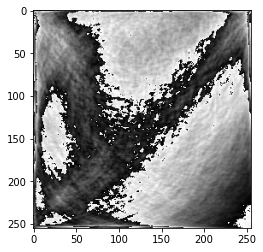

In [ ]:
# Some image generation
# If you want to display the images, uncomment below
centroids = pickle.load( open( "centroids.p", "rb" ) )
path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac")
plt.imshow(centroids["banana"], cmap="gray")
# plt.show()
# plt.savefig(path +'/centroids/banana.png')
label = "lmao"
plt.savefig(path +'/centroids/'+label+'.png')


# KNN With sklearn

In [53]:
# train_data, train_label = get_centroids()

def getTrainData(centroid=False, clusters=False):
  train_data = []
  train_label = []

  if centroid or clusters:
    print("here")
    train_data, train_label = get_centroids(clusters=clusters)
    print("Loaded in centroid as training data")

  else:
    train_data_file = open( flattened_data_path + "/smaller_train_data.p", "rb" )
    train_label_file = open( flattened_data_path + "/smaller_train_label.p", "rb" )

    pickle_loads = 0
    while True:
      try:
        pickle_loads += 1
        train_data += pickle.load(train_data_file)
        train_label += pickle.load(train_label_file)
      except EOFError:
        break

    print("Finished loading training data and labels.")
    print("Total number of pickle loads: {}".format(pickle_loads))

  return train_data, train_label


train_data, train_label = getTrainData(centroid=True, clusters=True)
# print(train_data,train_label)
print(len(train_label))

#create label encoder to turn categorial label to number
le = preprocessing.LabelEncoder()
le.fit(train_label)
train_label = le.transform(train_label)
print("label encoded train_label")

here
HIHIHIHI True
Loaded in centroid as training data
560
label encoded train_label


In [55]:
'''
Train KNN Model
'''
#reshape train_data to 2D
train_data = flatten_data(train_data)

#create scaler to normalize test data
# scaler = MinMaxScaler()
# print("before", train_data)
# scaler = StandardScaler()
# train_data = scaler.fit_transform(train_data)
# print("after", train_data)

#create model
model = OneVsRestClassifier(KNeighborsClassifier())
# model = KNeighborsClassifier()
model.fit(train_data, train_label)


(560, 784)


OneVsRestClassifier(estimator=KNeighborsClassifier())

In [60]:
ltemp = le.inverse_transform(train_label)
idx = np.where(ltemp == "toaster")
idx2 = np.where(ltemp == "apple")
print(idx)
# print(train_data[idx])
# print(train_data[idx2])
print("dist is", np.linalg.norm(train_data[idx]-train_data[idx2]))


(array([508, 509, 510, 511]),)
dist is 2125.065152284709


In [77]:
'''
Test model
'''
dat = open( flattened_data_path + "/smaller_test_data.p", "rb" )
lab = open( flattened_data_path + "/smaller_test_label.p", "rb" )

#predict output
total_data, total_correct = 0, 0
accuracy_class = {}
analyze = []

load = 0 
while True:
  try:
    print("Load: ", load)
    load += 1

    temp = pickle.load(dat)
    if len(temp) <= 0:
      print('no data left')
      break
    test_data = flatten_data(np.array(temp))
    test_label = np.array(pickle.load(lab))

    #transform
    # print("before", test_data)
    # test_data[test_data == 255] = 1
    # print("before 0.5", test_data) 
    # test_data = scaler.transform(test_data)
    # print("after", test_data)
    test_label = le.transform(test_label) #encode

    predicted = model.predict(test_data)
    print("Predictions: ", le.inverse_transform(predicted))
    print(predicted[0], le.inverse_transform(test_label)[0])

    total_correct += accuracy_score(test_label,predicted, normalize=False)
    total_data += len(predicted)
    acc = accuracy_score(test_label,predicted).astype(float)
    print('KNN Accuracy: %.3f' % acc)
    accuracy_class[le.inverse_transform(test_label)[0]] = acc #to track classes with best accuracy
    if acc > 0.2:
      analyze.append((acc,test_data,le.inverse_transform(predicted))) #(acc,test,data)

    # break
    
  except EOFError:
    break


print("=======================================")
print("RESULTS: ")
print(total_correct / total_data)

Load:  0
Predictions:  ['house plant' 'sailboat' 'The Eiffel Tower' 'house plant'
 'The Eiffel Tower' 'kangaroo' 'shovel' 'syringe' 'octopus' 'tent' 'bee'
 'sailboat' 'cello' 'mosquito' 'syringe' 'The Eiffel Tower']
56 The Eiffel Tower
KNN Accuracy: 0.188
Load:  1
Predictions:  ['toaster' 'paper clip' 'The Mona Lisa' 'pants' 'The Mona Lisa'
 'The Mona Lisa' 'stove' 'sea turtle' 'telephone' 'harp' 'butterfly'
 'teddy-bear' 'The Mona Lisa' 'skull' 'The Mona Lisa' 'The Mona Lisa']
128 The Mona Lisa
KNN Accuracy: 0.375
Load:  2
Predictions:  ['mailbox' 'camel' 'strawberry' 'camel' 'toaster' 'submarine' 'submarine'
 'sink' 'angel' 'skull' 'angel' 'skull' 'scorpion' 'syringe' 'snail'
 'angel' 'angel' 'monkey' 'star' 'angel' 'mermaid' 'syringe' 'angel' 'bee'
 'angel' 'angel' 'toilet' 'bee' 'windmill' 'bee' 'shark' 'angel']
68 angel
KNN Accuracy: 0.281
Load:  3
Predictions:  ['banana' 'saxophone' 'rhinoceros' 'zebra' 't-shirt' 'light bulb' 'train'
 'zebra' 'toilet' 'tiger' 'keyboard' 'house' '

In [65]:
'''
Save model
'''
pickle.dump( model, open(flattened_data_path + "/19percent.sav", "wb" ) )
print("Saved model")


Saved model


In [80]:
# top5 = dict(sorted(accuracy_class.items(), key=operator.itemgetter(1), reverse=True)[:5])
# print("top 5 class accuracies")
# print(top5)
print(accuracy_class)
temp = dict(sorted(accuracy_class.items(), key=lambda x: x[1], reverse=True)[:5])
print(temp)
temp2 = dict(sorted(accuracy_class.items(), key=lambda x: x[1], reverse=False)[:5])
print(temp2)

{'The Eiffel Tower': 0.1875, 'The Mona Lisa': 0.375, 'angel': 0.28125, 'ant': 0.0, 'apple': 0.5625, 'banana': 0.125, 'bathtub': 0.0, 'beach': 0.0, 'beard': 0.15625, 'bee': 0.1875, 'binoculars': 0.08333333333333333, 'bird': 0.041666666666666664, 'book': 0.0625, 'bowtie': 0.3125, 'brain': 0.09375, 'broccoli': 0.125, 'bucket': 0.4375, 'bulldozer': 0.0, 'butterfly': 0.25, 'cake': 0.0, 'camel': 0.0, 'camera': 0.125, 'ceiling fan': 0.0625, 'cello': 0.28125, 'clock': 0.3125, 'compass': 0.625, 'computer': 0.08, 'cow': 0.0, 'dog': 0.0625, 'dolphin': 0.18181818181818182, 'dragon': 0.0, 'drums': 0.0, 'ear': 0.125, 'elbow': 0.0, 'elephant': 0.0625, 'eye': 0.0625, 'eyeglasses': 0.15625, 'face': 0.15625, 'fireplace': 0.034482758620689655, 'flamingo': 0.0, 'flip flops': 0.0, 'foot': 0.03125, 'fork': 0.5625, 'garden': 0.0, 'giraffe': 0.1875, 'grapes': 0.125, 'hand': 0.10416666666666667, 'harp': 0.10526315789473684, 'hat': 0.11904761904761904, 'headphones': 0.5625, 'hedgehog': 0.125, 'helicopter': 0.03